# Import Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

tf.config.set_visible_devices([], 'GPU')


2025-07-15 14:46:00.297048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 14:46:00.304842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752561960.313724    5915 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752561960.316438    5915 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752561960.323357    5915 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Exploratory Data Analysis

In [3]:
ROOT = "../../datasets_all2/"
SEED = 88
IMG_SIZE = (150, 150)    # load at original size first
BATCH_SIZE = 128
LABEL_MODE = "categorical" # one‑hot labels straight away
AUTOTUNE = tf.data.AUTOTUNE

label_map={
    "broccoli":[1,0],
    "cauliflower":[0,1],
    "unknown":[0,0]
}
classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]
def data_generator(split):
    for class_name in label_map.keys():
        class_dir = os.path.join(ROOT, split, class_name)
        print(class_name)
        for fname in os.listdir(class_dir):
            img_path = os.path.join(class_dir, fname)
            
            yield img_path, label_map[class_name]


def process(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img, label


train_ds_pre = tf.data.Dataset.from_generator(
    lambda: data_generator("train"),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(2,), dtype=tf.float32)
    )
)
train_ds_pre = train_ds_pre.map(process, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(1000,SEED)

val_ds_pre = tf.data.Dataset.from_generator(
    (lambda: data_generator("validate")),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(2,), dtype=tf.float32)
    )
)
val_ds_pre = val_ds_pre.map(process, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(1000,SEED)

test_ds_pre = tf.data.Dataset.from_generator(
    (lambda: data_generator("test")),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(2,), dtype=tf.float32)
    )
)
test_ds_pre = test_ds_pre.map(process, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(1000,SEED)



,broccoli,cauliflower,unknown,splits total
test,257,272,232,761
train,2163,2191,1858,6212
validate,257,271,232,760
img total,2677,2734,2322,7733


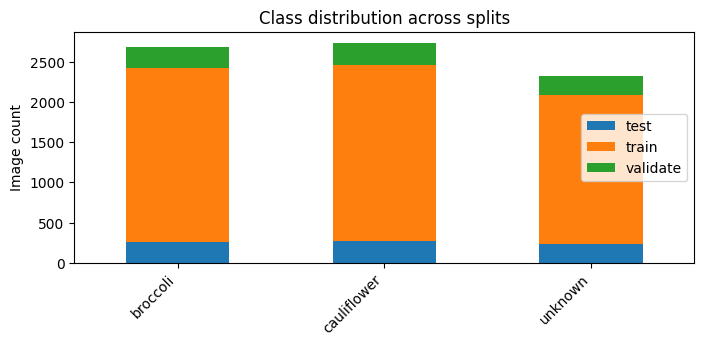

In [4]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

broccoli
cauliflower
unknown


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

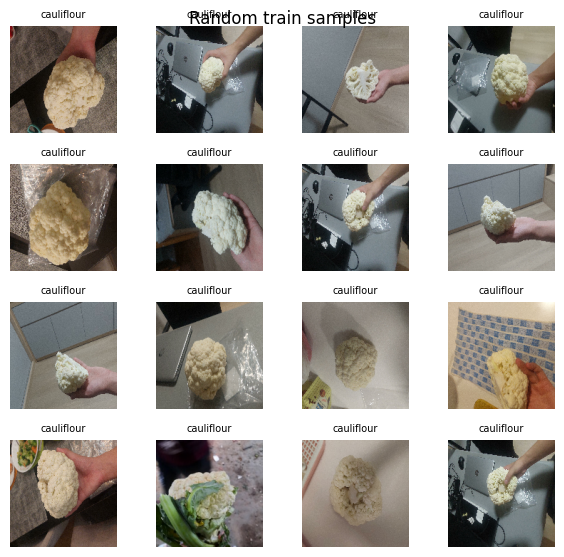

In [5]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow((images[i].numpy()).astype("uint8"))
        innertext="unknown"
        if (labels[i][1]):
            innertext="cauliflour"
        elif (labels[i][0]):
            innertext="broccoli"
        
        plt.title(innertext, fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
TARGET_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom((0.3), 0.3),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)


broccoli
cauliflower
unknown


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

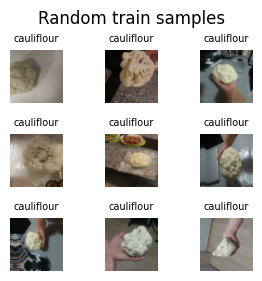

In [7]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        innertext="unknown"
        if (labels[i][1]):
            innertext="cauliflour"
        elif (labels[i][0]):
            innertext="broccoli"
        plt.title(innertext, fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [8]:
num_classes = 2

model = keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(*IMG_SIZE, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation='sigmoid'))  # 2 outputs for multi-label
model.summary()

Optimizer = optimizers.Adam(0.001)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=Optimizer,
    metrics=[
        'binary_accuracy'
    ]
)

/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,598,114 (21.36 MB)

 Trainable params: 5,596,962 (21.35 MB)

 Non-trainable params: 1,152 (4.50 KB)

NameError: name 'Precision' is not defined

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    epochs=25,
    verbose=1,
    batch_size=BATCH_SIZE,
    validation_data = val_ds
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights('model.weights.h5')
tf.keras.models.save_model(model,'model.keras')

# Model Evalutation

In [ ]:

pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['binary_accuracy'], label='train acc')
plt.plot(history.history['val_binary_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()